# Examples from paper

In this notebook we will use [shenfun](https://github.com/spectralDNS/shenfun) to solve the example problems from the paper

    M Mortensen, "A generic and strictly banded spectral Petrov-Galerkin method for differential equations with polynomial coefficients"

For the solution we will use ultraspherical polynomials $Q^{(\alpha)}_n(x)$ defined as 

$$
Q^{(\alpha)}_n(x) = g_n^{(\alpha,\alpha)} P^{(\alpha,\alpha)}_n(x),
$$

where $P^{(\alpha,\beta)}_n$ is the regular $n$'th [Jacobi polynomial](https://en.wikipedia.org/wiki/Jacobi_polynomials) with parameters $\alpha, \beta$ both $ >-1$. The scaling function $g_n^{(\alpha,\alpha)}$ is defined as $1/P^{(\alpha,\alpha)}_n(1)$ for both Chebyshev and Legendre polynomials and generic ultraspherical polynomials. We have the following

$$
\begin{align}
T_n(x) &= Q^{(-1/2)}_n, \\
L_n(x) &= Q^{(0)}_n, \\
U_n(x) &= (n+1)Q^{(1/2)}_n
\end{align}
$$

where $T_n, U_n$ are the Chebyshev polynomials of first and second kind and $L_n$ are the Legendre polynomials. Note that Chebyshev polynomials of the second kind uses slightly different scaling than the others.

Note that the code below can use any of these specific ultraspherical polynomials, and in general any $\alpha>-1$. However, the code for a generic $\alpha$ is less optimized than choosing these specific bases, and in particular do not include fast transforms.

We will make use of a test function $\phi^{(k)}_n$ defined for integer $k$ as

$$
\phi^{(k)}_n = \frac{(1-x^2)^k}{h^{(k,\alpha)}_{n+k}} \frac{d^k Q^{(\alpha)}_{n+k}}{dx^k},
$$

where

$$
h^{(k,\alpha)}_{n+k} = \int_{-1}^1 \left(\frac{d^k Q^{(\alpha)}_{n+k}}{dx^k}\right)^k \omega^{\alpha+k} dx,
$$

and the weight $\omega^{\alpha}=(1-x^2)^{\alpha}$.


# Example 1

We consider the first order problem

\begin{equation}
    u'(x)+\frac{1}{x^2+1}u(x)=s(x), \quad u(-1) = 0, \quad x \in [-1, 1], \label{eq:firstproblem}
\end{equation}

For this first order problem we use the trial space $\text{S}_N=\text{span}\{\psi_n\}_{n=0}^{N-1}$ with basis function $\psi_n=Q^{(\alpha)}_n+Q^{(\alpha)}_{n+1}$, corresponding to a stencil matrix $K=(\delta_{mn}+\delta_{m+1,n})_{m=0,n=0}^{N-1, N} \in \mathbb{R}^{N\times N+1}$. Next, we multiply through with $x^2+1$ to get only polynomial coefficients, and attempt to find $u\in \text{S}^{(1)}_N$ such that

\begin{equation}
    ((x^2+1) u', v)_{\omega} + (u, v)_{\omega} = (f, v)_{\omega}, \quad \forall v \in \text{V}^{(1)}_{N+1} = \text{span}\{\phi^{(1)}_n\}_{n=0}^{N-1},
\end{equation}

where $f(x) = (x^2+1) s(x)$. 


We start by importing functionality from shenfun and [sympy](www.sympy.org)

In [1]:
import sympy as sp
from shenfun import *
from shenfun.jacobi.recursions import half, cn, Lmat
config['assembly']['splitmeasure'] = True

Define the manufactured solution $u(x)=\exp(-0.25x^4)(x+1)$.

In [2]:
x = sp.Symbol('x', real=True)
ue = sp.exp(-x**4/4)*(x+1)
fe = (x**2+1)*sp.diff(ue, x, 1) + ue

Note that any function will do, but this one has a homogeneous boundary condition for `x=0`. If the solution does not have a homogeneous boundary condition, then simply change the SN space below to `SN = FunctionSpace(N, family, bc=(ue.subs(x, -1), None))`.

Below we create a function `main` that will solve the problem using three differen techniques. Using `method=1` corresponds to a pure Petrov-Galerkin method, computing integrals with high precision. For `method=2` we restrict the right hand side function to the space $\text{P}_{N+1}$, whereas in `method=3` we restrict to $\text{P}_{N}$. 

In [3]:
def main(N, method=1, family='C', alpha=0.5, returnmat=False):
    """Method for solving Eq. (2)
    
    Parameters
    ----------
    N : integer
        The number of quadrature points
    method : number in (1, 2, 3), optional
        The choice of method
        - 1 pure Petrov Galerkin
        - 2 Numerical - restrict f to $P_{N+1}$
        - 3 Numerical - restrict f to $P_{N}$
    family : str, optional
        - Chebyshev
        - Legendre
        - Ultraspherical
        - ChebyshevU
    alpha : number > -1, optional
        Parameter used only if family is Ultrasperical
    returnmat : boolean, optional
        Whether to simply return the coefficient matrix without computing the error
    """
    SN = FunctionSpace(N, family, bc=(0, None), alpha=alpha)
    VN = FunctionSpace(N+1, family, basis='Phi1', alpha=alpha)
    u = TrialFunction(SN)
    v = TestFunction(VN)
    D = inner((x**2+1)*grad(u), v)
    M = inner(u, v)
    D += M if isinstance(M, list) else [M]
    if returnmat:
        return np.sum(np.array(D, dtype=object))

    sol = la.Solver(D)
    u_hat = Function(SN)
    X = SN.mesh()
    ul = sp.lambdify(x, ue)
    uq = Array(SN, buffer=np.array([ul(j) for j in X]))
    
    if method == 1:
        M = 400 # Just some high number. Much smaller will do
        VM = FunctionSpace(M, family, basis='Phi1')
        fM = Function(VM)
        fM = VM.scalar_product(Array(VM, buffer=fe), fM)
        f_hat = Function(VN)
        f_hat[:N-1] = fM[:N-1]
        u_hat = sol(f_hat, u_hat)
    elif method == 2:
        T = VN.get_orthogonal()
        fN = Array(T, buffer=fe)
        f_hat = inner(v, fN)
        u_hat = sol(f_hat, u_hat)
    elif method == 3: # quasi
        T = SN.get_orthogonal()
        fN = Function(T, buffer=fe).refine(N+1)
        f_hat = inner(v, fN)
        u_hat = sol(f_hat, u_hat)

    uj = u_hat.backward()
    error = np.sqrt(inner(1, (uj-uq)**2))
    return error

Finally, solve problem for a range of different quadrature points and plot the $L^2$ error. Below we use Chebyshev, but any ultraspherical polynomial will do.

<IPython.core.display.Javascript object>


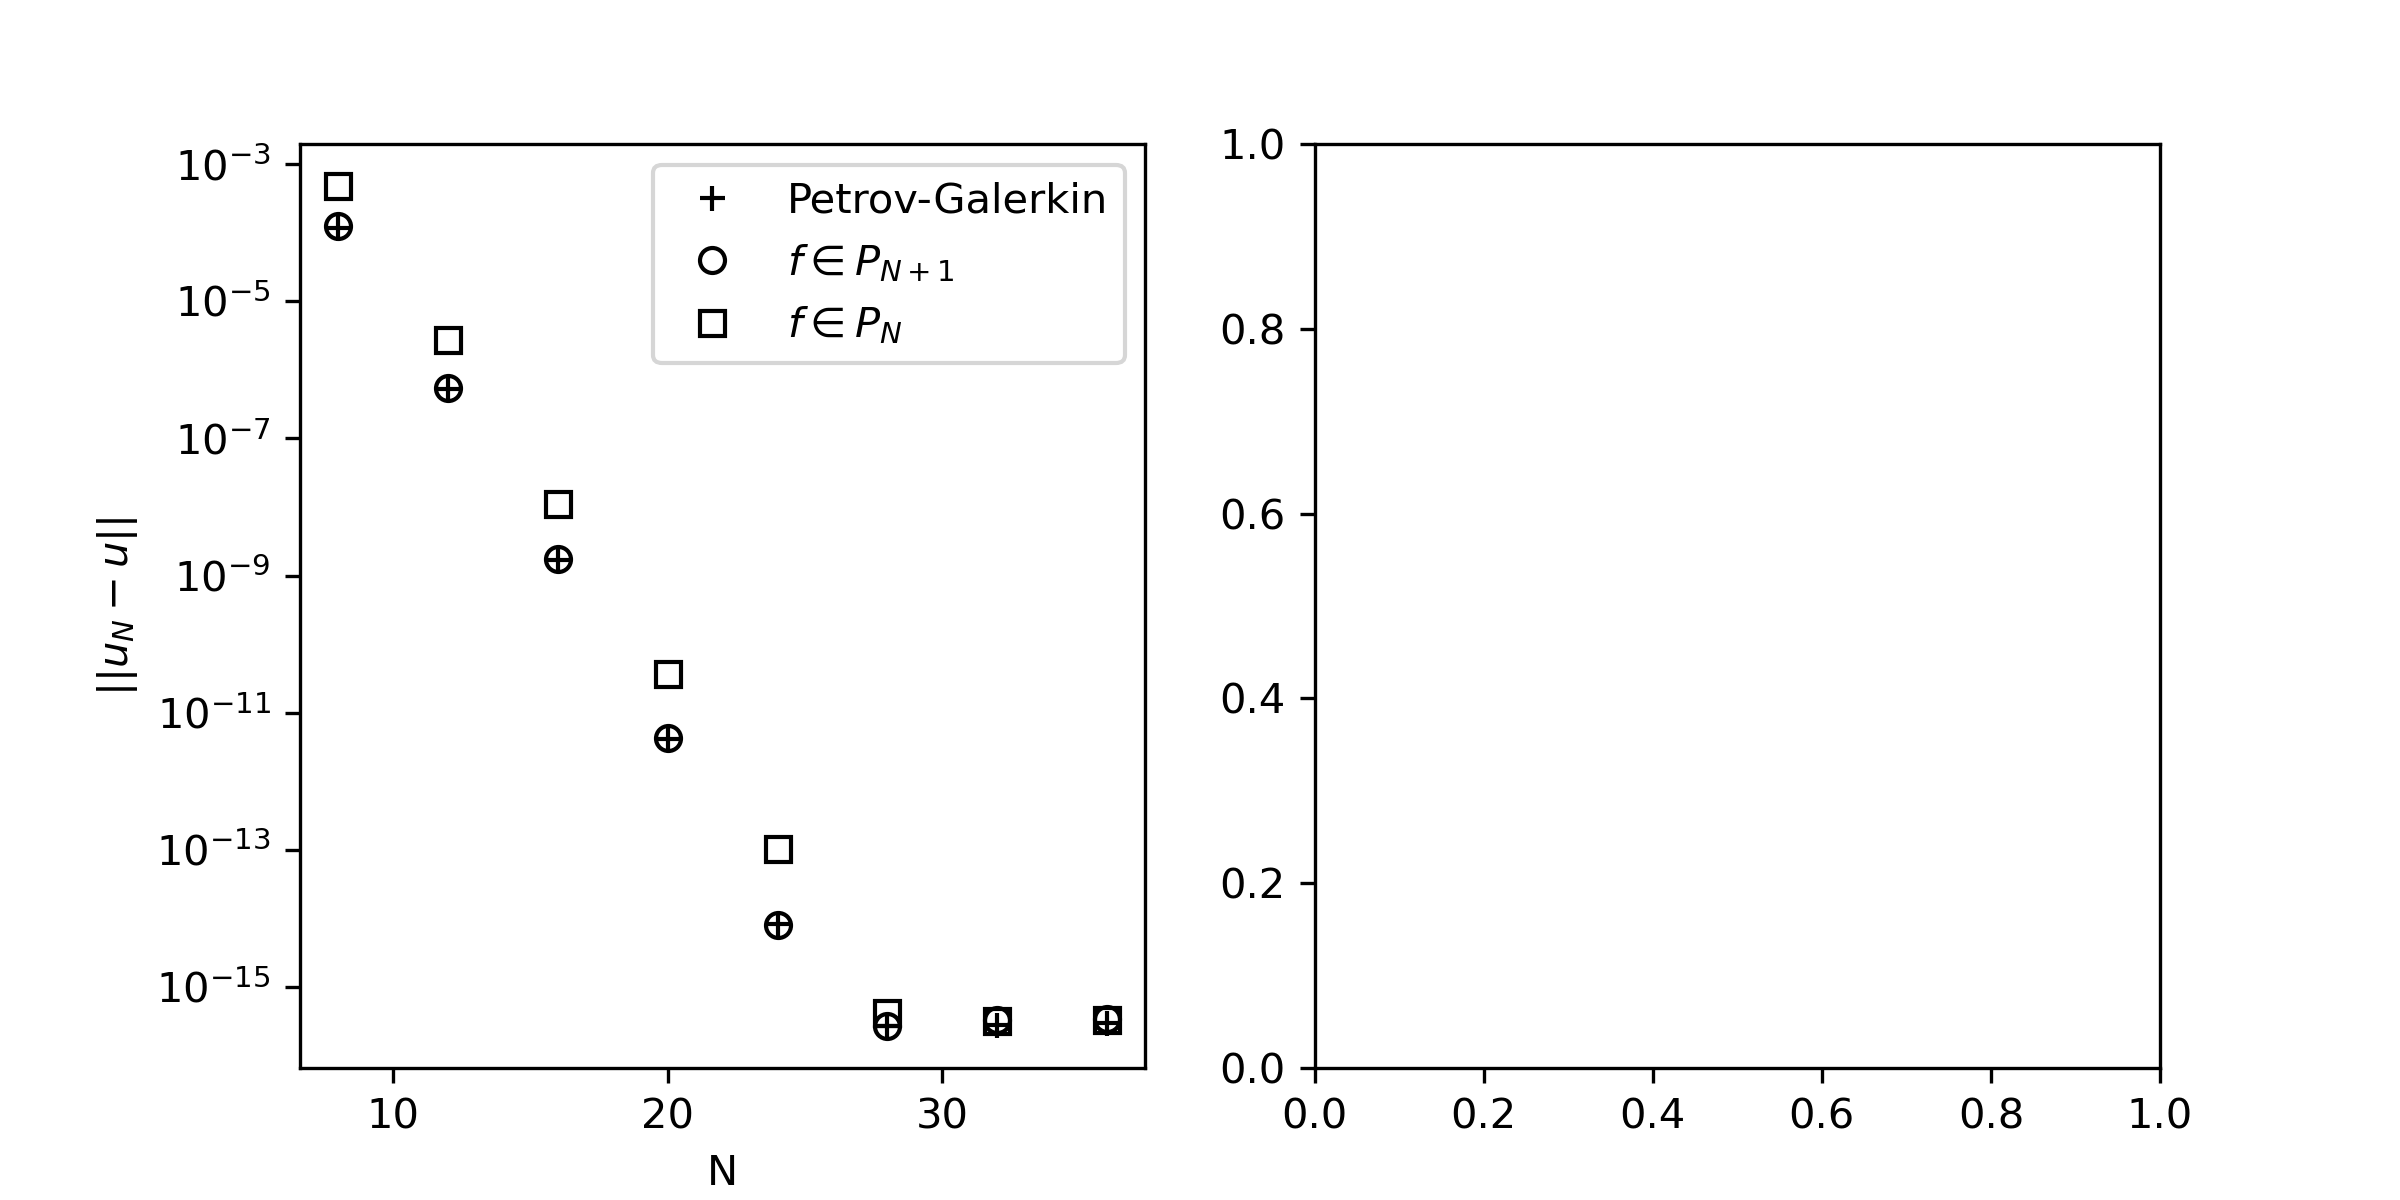

AttributeError: 'numpy.float64' object has no attribute 'diags'

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
cols = ('k',)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for c, fam in zip(cols, 'C'):
    error = {}
    M = np.arange(8, 40, 4)
    for method in (1, 2, 3):
        error[method] = []
        for N in M:
            error[method].append(main(N, method, fam))
    ax[0].semilogy(M, error[1], '+', M, error[2], 'o', M, error[3], 's', fillstyle='none', color=c)
ax[0].legend(['Petrov-Galerkin', '$f \in {P}_{N+1}$', '$f \in {P}_{N}$'])
ax[0].set(xlabel='N', ylabel='$||u_N-u||$')
ax[1].spy(main(20, 2, 'C', True).diags(), markersize=5, mec='k', mfc='k', marker='o', aspect='auto')
plt.show()
